In this notebook, we will run a ready-made network starting from some ATLAS data, which is already normalized. There is also an alternative to train the network from scratch.  

## Look into the dataset

First we need to make sure that Python 3.8 is used in the notebook. It is required in order to open this certain .pkl-file. 

In [4]:
import sys
sys.version

'3.8.3 (tags/v3.8.3:6f8c832, May 13 2020, 22:37:02) [MSC v.1924 64 bit (AMD64)]'

We take a pickle dataset, and open into Pandas (after importing pandas). Note that you have to change the paths to the directory where your processed files are. 

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

data_path = Path('monojet_Zp2000.0_DM_50.0_chan3.csv')

data = dict()
with open(data_path, 'r') as f:
        for line in f:
            
            split = line.strip().split(';')
            first_five = ''.join(split[0:4])
            objs = split[5:]
            
            jets = []
            for obj in objs:
                split_obj = obj.strip().split(',')                
                if 'j' in split_obj:
                    jets.append([float(i) for i in split_obj[1:]])
                    
            data[first_five] = jets
            counter += 1


combined_jets = [jet for event in data.values() for jet in event]
df = pd.DataFrame.from_records(combined_jets)
df.columns = ["E","pt","eta","phi"]

train, test = train_test_split(df, test_size=0.2)


# To get an idea of the order of magnitude we are going to see in the plots we show the first elements 
# in the samples:
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))

Training sample:
               E        pt       eta       phi
22402   654824.0  652820.0 -0.049131 -0.266934
13244   117033.0   82004.2 -0.879725  3.122690
3016    965929.0  630348.0 -0.974154  1.199730
2788   1027840.0  485898.0 -1.380990  1.654960
6819     81228.6   24426.2 -1.869130 -1.916930


Testing sample:
              E        pt       eta      phi
21471  768840.0  436852.0 -1.164990 -3.07673
9493   300802.0  264370.0 -0.509090 -2.57014
20146  787673.0  280942.0 -1.684800  2.59532
3643   112849.0  100159.0 -0.482628  1.32433
5090   259125.0   71184.2 -1.964510 -2.75708


The number of entries in the training data: 18063
The number of entries in the validation data: 4516


Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

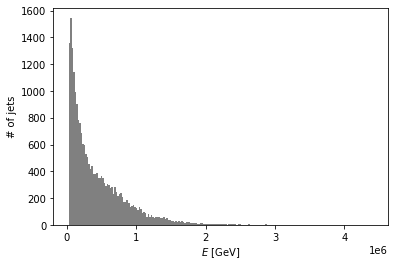

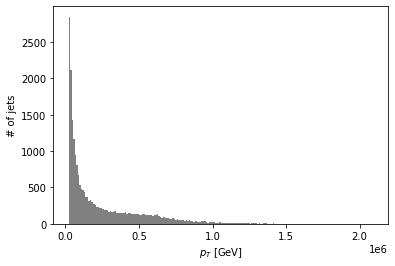

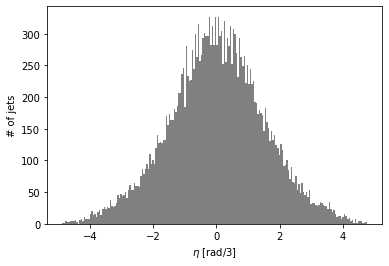

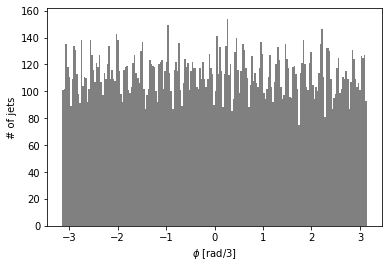

In [54]:
import matplotlib.pyplot as plt

unit_list = ['[GeV]', '[GeV]', '[rad/3]', '[rad/3]']
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']

branches=["E","pt","eta","phi"]

n_bins = 200

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(df[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of jets')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [108]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [109]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [110]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

## Training the network

First, we want to find the best learning rate. The learning rate is a hyper-parameter that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 6.309573450380412e-08
Learning rate with the steepest gradient: 3.981071586167673e-06


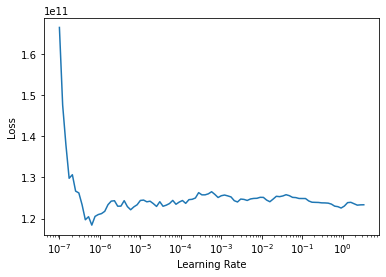

In [111]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [62]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 125190561792.0, 124424339456.0, '00:00']
[0, 125190561792.0, 124424339456.0, '00:00']
[1, 125443694592.0, 124418138112.0, '00:00']
[1, 125443694592.0, 124418138112.0, '00:00']
[2, 124469141504.0, 124410241024.0, '00:00']
[2, 124469141504.0, 124410241024.0, '00:00']
[3, 124420857856.0, 124399722496.0, '00:00']
[3, 124420857856.0, 124399722496.0, '00:00']
[4, 124150382592.0, 124385681408.0, '00:00']
[4, 124150382592.0, 124385681408.0, '00:00']
[5, 124554625024.0, 124367421440.0, '00:00']
[5, 124554625024.0, 124367421440.0, '00:00']
[6, 125370597376.0, 124344139776.0, '00:00']
[6, 125370597376.0, 124344139776.0, '00:00']
[7, 124959219712.0, 124315156480.0, '00:00']
[7, 124959219712.0, 124315156480.0, '00:00']
[8, 125646176256.0, 124280061952.0, '00:00']
[8, 125646176256.0, 124280061952.0, '00:00']
[9, 124907118592.0, 124238307328.0, '00:00']
[9, 124907118592.0, 124238307328.0, '00:00']
[10, 124757508096.0, 124189630464.0, '00:00']
[10, 124757508096.0, 124189630464.0, '00:00']
[11, 125

[90, 119203569664.0, 118460112896.0, '00:00']
[90, 119203569664.0, 118460112896.0, '00:00']
[91, 118066020352.0, 118456492032.0, '00:00']
[91, 118066020352.0, 118456492032.0, '00:00']
[92, 120010702848.0, 118453665792.0, '00:00']
[92, 120010702848.0, 118453665792.0, '00:00']
[93, 119897333760.0, 118451511296.0, '00:01']
[93, 119897333760.0, 118451511296.0, '00:01']
[94, 119444660224.0, 118449979392.0, '00:01']
[94, 119444660224.0, 118449979392.0, '00:01']
[95, 120265285632.0, 118448947200.0, '00:01']
[95, 120265285632.0, 118448947200.0, '00:01']
[96, 120965193728.0, 118448340992.0, '00:01']
[96, 120965193728.0, 118448340992.0, '00:01']
[97, 119087595520.0, 118448005120.0, '00:01']
[97, 119087595520.0, 118448005120.0, '00:01']
[98, 118637576192.0, 118447882240.0, '00:01']
[98, 118637576192.0, 118447882240.0, '00:01']
[99, 118799179776.0, 118447865856.0, '00:01']
[99, 118799179776.0, 118447865856.0, '00:01']
Training took 99.42554669996025 seconds


Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

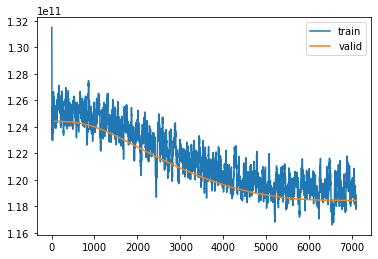

In [63]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [64]:
learn.validate()

(#1) [118447865856.0]

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [65]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [72]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = 10**df['E']
    df['pt'] = 10**(df['pt'])
    return df

Make the histograms from the dataset...

ValueError: supplied range of [inf, inf] is not finite

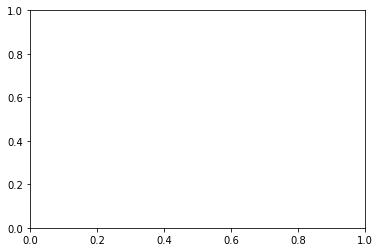

In [106]:
import numpy as np

plt.close('all')
unit_list = ['[GeV]', '[rad/3]', '[rad/3]', '[GeV]']
variable_list = [ r'$E$', r'$p_T$', r'$\eta$', r'$\phi$',]
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = False # Option to save figure

# Histograms
idxs = (0, 1000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
pred = model(data)

data_df = pd.DataFrame.from_records(data, columns=branches)
pred_df = pd.DataFrame.from_records(pred, columns=branches)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in range(0, 4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data_df[branches[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred_df[branches[kk]], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

In [38]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
#print(rat)